#Gesture-Phase-Segmentation_load_dataset.ipynb
Loads the dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/gesture+phase+segmentation) and returns train and test X/y numpy arrays.  This loader derived from TWRistAR version Feb'22.   Please follow the original dataset owners citation requests if you use this data in your work.

The basic flow is:
* Download and unzip the dataset if not already present
* Convert each recording *session* into Intermediate Representation 1 (IR1) format - a datetime indexed pandas dataframe with columns for each channel plus the label and subject number.
* Transform the IR1 into IR2 - a set of three numpy arrays containing sliding window samples
   * X = (samples, time steps per sample, channels)  
   * y =  (samples, label) # activity classification  
   * s =  (samples, subject) # subject number
* Clean and further transforms the IR2 arrays as needed - note the transforms that can be applied here are train vs test dependent.   For example, the IR2 arrays in the training set may be rebalanced, but those in the test set should not.
* Concatenate the processed IR2 arrays into the final returned train/validate/test arrays.

Set interactive to true to run the Jupyter Notebook version.  Note most of the calls are setup to test the functions, not process the entire dataset, to do that set interactive to false and run all so that main executes.   This notebook can be saved and run as a python file as well.


<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

[Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  
TODO:
* Some files (a1_raw) have time discontinuity.  Need to address when forming sliding windows.


In [1]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
import time
import pandas as pd
import numpy as np
from numpy import savetxt
from tabulate import tabulate # for verbose tables, showing data
from tensorflow.keras.utils import to_categorical # for one-hot encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from time import gmtime, strftime, localtime #for displaying Linux UTC timestamps in hh:mm:ss
from datetime import datetime, date
import urllib.request # to get files from web w/o !wget
import matplotlib.pyplot as plt

# Global Parameters

In [2]:
# environment and execution parameters
my_dir = '.' # replace with absolute path if desired
dataset_dir = os.path.join(my_dir,'gesture_phase_dataset') # Where dataset will be unzipped

interactive = True # for exploring data and functions interactively
verbose = True

# dataset parameters

In [3]:
# interactive = False # don't run if interactive, automatically runs for .py version
# verbose = False # to limit the called functions output

In [4]:
def get_gesture_phase_dataset():
    """checks for local zipfile, if none downloads from UCI repository
    after download will unzip the dataset into local directory.
    Assumes a global my_dir has been defined (default is my_dir = ".")
    :return: nothing"""
    zip_fname = 'gesture_phase_dataset.zip'
    zip_ffname = os.path.join(my_dir,zip_fname)
    gps_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00302/gesture_phase_dataset.zip"
    if (os.path.exists(zip_ffname)):
        if verbose:
            print ("Local",zip_ffname, "found, skipping download")
    else:
        print("Downloading Gesture-Phase-Segmentation dataset from UCI ML Repository")
        urllib.request.urlretrieve(gps_url, zip_fname)
    if (os.path.isdir(dataset_dir)):
        if verbose:
            print("Found existing directory:", dataset_dir, "skipping unzip")
    else:
        os.makedirs(dataset_dir)
        print("Unzipping Gesture Phase Segmentation file in", dataset_dir, "directory")
        if (os.path.exists(zip_ffname)):
            shutil.unpack_archive(zip_ffname,dataset_dir,'zip')
        else:
            print("Error: ", zip_ffname, " not found, exiting")
    return
if interactive:
    get_gesture_phase_dataset()

Unzipping Gesture Phase Segmentation file in ./gesture_phase_dataset directory


In [5]:
def get_gps_ir1_list():
    """reads the Gesture-Phase-Segmentation raw .csv files in the global
    'dataset_dir'.   Works but I think dict is better see get_gps_ir1_dict
    Returns: a list containing IR1 dataframes."""
    fn_list = ['a1_raw.csv', 'a2_raw.csv', 'a3_raw.csv',
           'b1_raw.csv', 'b3_raw.csv', 'c1_raw.csv','c3_raw.csv']
    ir1_df_list = list() # an empty list
    for item in fn_list:
        subject = item[0] # the first letter of the filename a,b,c
        story = item[1] # the number after subject letter, 1,2,3
        ffname = os.path.join(dataset_dir,item)
        print(subject, story, ffname)
        df = pd.read_csv(ffname)
        df['subject'] = subject
        df['story'] = story
        # kinect sample rate is 15 or 30 fps, timestamp appears to
        # be a running counter not an actual UTC time.
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms') 
        df.set_index('datetime',inplace=True)
        df = df.drop('timestamp', axis=1)
        ir1_df_list.append(df)
    return ir1_df_list
if interactive:
    df_list = get_gps_ir1_list()

a 1 ./gesture_phase_dataset/a1_raw.csv
a 2 ./gesture_phase_dataset/a2_raw.csv
a 3 ./gesture_phase_dataset/a3_raw.csv
b 1 ./gesture_phase_dataset/b1_raw.csv
b 3 ./gesture_phase_dataset/b3_raw.csv
c 1 ./gesture_phase_dataset/c1_raw.csv
c 3 ./gesture_phase_dataset/c3_raw.csv


In [6]:
def get_gps_ir1_dict():
    """reads the Gesture-Phase-Segmentation raw .csv files in the global
    'dataset_dir'. This version uses dict to preserve original filenames.
    Returns: a list containing IR1 dataframes."""
    fn_list = ['a1_raw.csv', 'a2_raw.csv', 'a3_raw.csv',
           'b1_raw.csv', 'b3_raw.csv', 'c1_raw.csv','c3_raw.csv']
    ir1_df_dict = dict() # an empty dictionary
    for item in fn_list:
        subject = item[0] # the first letter of the filename a,b,c
        story = item[1] # the number after subject letter, 1,2,3
        ffname = os.path.join(dataset_dir,item)
        # print(subject, story, ffname)
        df = pd.read_csv(ffname)
        # change to 32-bit, credit/ref https://stackoverflow.com/questions/69188132/how-to-convert-all-float64-columns-to-float32-in-pandas
        # Select columns with 'float64' dtype  
        float64_cols = list(df.select_dtypes(include='float64'))
        # The same code again calling the columns
        df[float64_cols] = df[float64_cols].astype('float32')
        # Seems better to explicitly type the other columns vs object.
        df['phase']=df['phase'].astype('string')
        df['sub'] = subject
        df['sub'] = [ ord(x) - 96 for x in df['sub']] # ord is unicode char
        df['sub']=df['sub'].astype('int8')
        df['story'] = story
        df['story']=df['story'].astype('int8')
        df.rename(columns={"phase": "label"}, inplace = True, errors="raise") # phase was GPS dataset specific

        # kinect sample rate is 15 or 30 fps, timestamp appears to
        # be a running counter not an actual UTC time.
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms') 
        df.set_index('datetime',inplace=True)
        df = df.drop('timestamp', axis=1)
        ir1_df_dict[item.split('.')[0]]=df # key is root name of csv
    return ir1_df_dict
if interactive:
    df_dict = get_gps_ir1_dict()
    print(df_dict.keys())

dict_keys(['a1_raw', 'a2_raw', 'a3_raw', 'b1_raw', 'b3_raw', 'c1_raw', 'c3_raw'])


# Option to save/pickle the IR1 dataframes.

In [7]:
save_dir = 'gesture_phase_raw_ir1'
if (not os.path.isdir(save_dir)):
    os.mkdir(save_dir)

for df_name, ir1_df in df_dict.items() :
    ffname = os.path.join(save_dir,df_name) + '.pkl'
    ir1_df.to_pickle(ffname)

<class 'pandas.core.frame.DataFrame'>
lhx      float32
lhy      float32
lhz      float32
rhx      float32
rhy      float32
rhz      float32
hx       float32
hy       float32
hz       float32
sx       float32
sy       float32
sz       float32
lwx      float32
lwy      float32
lwz      float32
rwx      float32
rwy      float32
rwz      float32
label     string
sub         int8
story       int8
dtype: object


,lhx,lhy,lhz,rhx,rhy,rhz,hx,hy,hz,sx,...,sz,lwx,lwy,lwz,rwx,rwy,rwz,label,sub,story
datetime,,,,,,,,,,,,,,,,,,,,,
1970-01-01 01:35:02.026,5.347435,4.363681,1.501913,5.258967,4.319263,1.488703,5.037871,1.618295,1.778350,5.062803,...,1.772577,4.972902,4.301065,1.564781,5.553945,4.370456,1.553521,Rest,1,1
1970-01-01 01:35:02.058,4.869622,4.254210,1.556133,5.240113,4.346338,1.554309,5.037610,1.618370,1.778573,5.061430,...,1.772859,4.974908,4.303656,1.565527,5.423875,4.303708,1.569942,Rest,1,1
1970-01-01 01:35:02.089,5.357447,4.364039,1.500969,5.238928,4.347924,1.554150,5.037514,1.618298,1.778774,5.059245,...,1.773568,4.981612,4.305363,1.563643,5.332170,4.438061,1.572841,Rest,1,1
1970-01-01 01:35:02.120,4.942886,4.281878,1.546513,5.111436,4.229660,1.527091,5.037526,1.618612,1.778855,5.056475,...,1.774519,4.987158,4.304063,1.565929,5.311104,4.396774,1.566368,Rest,1,1
1970-01-01 01:35:02.167,5.003160,4.278530,1.542866,4.985812,4.182155,1.520330,5.037557,1.619226,1.778925,5.052367,...,1.775536,4.983912,4.296833,1.569889,5.193762,4.335417,1.560144,Rest,1,1


<AxesSubplot:xlabel='datetime'>

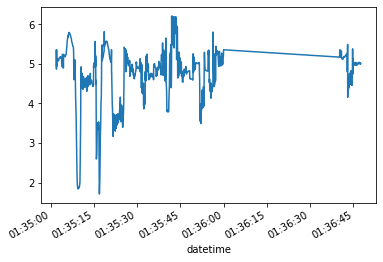

In [8]:
my_df = df_dict['a1_raw']
print(type(my_df))
print(my_df.dtypes)
display(my_df.head())
my_df['lhx'].plot()

<AxesSubplot:xlabel='datetime'>

1182 rows with gaps large than 30 found
Start of gap 1970-01-01 01:36:00.975000
 End of gap  1970-01-01 01:36:39.948000


<AxesSubplot:xlabel='datetime'>

<AxesSubplot:xlabel='datetime'>

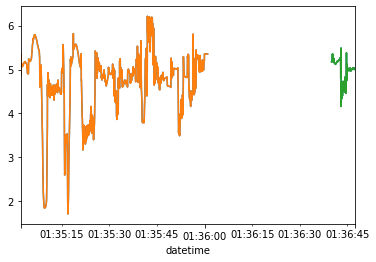

In [9]:
# find timegaps and split so that the resulting IR1 dataframes
# represent a continuous recording session
# use resampe/mean/interpolate to fill small gaps and make
# larger ones NaN.   Then get a dataframe of just the NaN
# rows and use that index to split the dataframe
# NOTE:  This is dataset specific in that it only handles one big gap
# Interesting that the plots merge and don't show separately
my_df = df_dict['a1_raw']
max_gaps_to_fill = 30
rs_df = my_df.resample('33ms').mean().interpolate(limit = max_gaps_to_fill)
display(rs_df['lhx'].plot()) # NaN will not be plotted by default
nan_rows = rs_df[rs_df['lhx'].isnull()] # notnull also available
if (len(nan_rows.index)==0):
    print("No gaps exceeding",max_gaps_to_fill,"found")
else:
    print(len(nan_rows.index), "rows with gaps large than",max_gaps_to_fill,"found")
    gap_start, gap_end = nan_rows.index[0], nan_rows.index[-1]
    print("Start of gap", gap_start)
    print(" End of gap ", gap_end)
    df1 = rs_df.loc[rs_df.index[0]:gap_start]
    df2 = rs_df.loc[gap_end:rs_df.index[-1]]
    display(df1['lhx'].plot())
    display(df2['lhx'].plot())
    df2 = df2.iloc[1:] # drop the one NaN row due to slice


array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

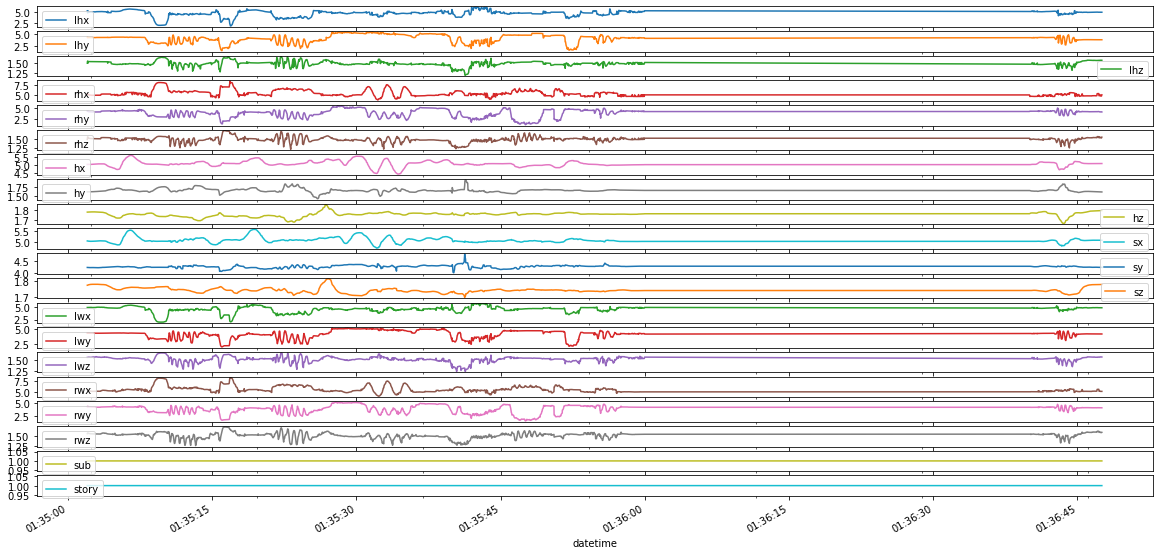

In [10]:
df_dict['a1_raw'].plot(subplots=True, figsize=(20, 10)) # yay Pandas

# Much of the code below will be moved in to Common Transforms notebook.

In [ ]:
def get_ir2_from_ir1(df):
    """slice the IR1 dataframe into sliding window segments of
    time_steps length and return X, y, sub ndarrays.
    If stride = time_steps there is no overlap of the sliding window.
    This version does not use append, better for RAM
    df: pandas datetime indexed dataframe columns - channel(s), label, sub
    Global params used
    time_steps: number of samples in window, will discard a partial final window
    stride:  how far to move window, no overlap if equal to time_steps.
    """    
    # this was copied from SHL with improved memory capabilities
    # the channel list is in dataframe but not in the numpy arrays
    channel_list = list(df.columns)
    channel_list.remove('label') # need to make sure this is defined for IR1
    channel_list.remove('sub') # ditto - should probably add a check
    if verbose:
        print('Channels in X:',channel_list)
    X = df[channel_list].to_numpy(dtype = 'float32')
    #y = df['label'].to_numpy(dtype = 'int8') # doesn't work for strings
    y = df['label'].to_numpy(dtype='<U10')
    sub = df['sub'].to_numpy(dtype = 'int8')
    if verbose:
        print('X,y,sub array shapes before sliding window', X.shape, y.shape, sub.shape)
    #https://numpy.org/devdocs/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html
    shapex = (time_steps,X.shape[1]) # samples (rows to include) and n-dim of original (all channels)
    shapey = (time_steps,) # samples (rows to include) and only one column
    shapesub = (time_steps,) # samples (rows to include) and only one column
    X = np.lib.stride_tricks.sliding_window_view(X, shapex)[::stride, :]
    X = X[:,0,:,:] # I admit I don't understand why this dimension appears...
    y = np.lib.stride_tricks.sliding_window_view(y, shapey)[::stride, :]
    sub = np.lib.stride_tricks.sliding_window_view(sub, shapesub)[::stride, :]
    if verbose:
        print('X,y,sub array shapes after sliding window', X.shape, y.shape, sub.shape)
    return X, y, sub, channel_list
if interactive:
    my_X, my_y, my_sub, all_channel_list = get_ir2_from_ir1(ir1_df)
    headers = ("array","shape", "object type", "data type")
    mydata = [("my_X:", my_X.shape, type(my_X), my_X.dtype),
            ("my_y:", my_y.shape ,type(my_y), my_y.dtype),
            ("my_sub:", my_sub.shape, type(my_sub), my_sub.dtype)]
    print("IR2 array info")
    print(tabulate(mydata, headers=headers))
    print("Returned all_channel_list", all_channel_list)

In [ ]:
def clean_ir2(X, y, sub):
    """removes sliding windows containing NaN, multiple labels, or multiple
    subject numbers.  Collapses y, sub to column arrays.
    Returns cleaned versions of X, y, sub ndarrays"""
    # Copied directly from SHL.  Yay!
    # Check for NaN
    nans = np.argwhere(np.isnan(X))
    num_nans = np.unique(nans[:,0]) #[:,0] just 1st column index of rows w/ NaN
    if verbose:
        print(num_nans.shape[0], "NaN entries found, removing")
    idx = ~np.isnan(X).any(axis=2).any(axis=1)
    # this warrants some explanation!
    # any(axis=1) and 2 collapses channels and samples
    # good axis explanation https://www.sharpsightlabs.com/blog/numpy-axes-explained/
    # the ~ negates so NaN location are now False in the idx which is then
    # used to filter out the bad windows below
    X = X[idx]
    y = y[idx]
    sub = sub[idx]
    # repeat and confirm NaNs have been removed
    nans = np.argwhere(np.isnan(X))
    num_nans = np.unique(nans[:,0]) #[:,0] accesses just 1st column
    if (nans.size!=0):
        print("WARNING! Cleaned output arrays still contain NaN entries")
        print("execute print(X[99]) # to view single sample")
    # Now get rid of segments with multiple labels
    # Not happy with this code, must be a better way but it seems to work...
    idx = []
    for i in range(y.shape[0]):
        if np.all(y[i] == y[i][0]):
            idx.append(True)
            
        else:
            idx.append(False)
            #print('Discarding Row:', i)
    X = X[idx]
    y = y[idx]
    sub = sub[idx]
    # TODO check for multiple subjects in window
    y = y[:,0] # collapse columns
    y = y[np.newaxis].T  # convert to single column array
    sub = sub[:,0] # repeat for sub array
    sub = sub[np.newaxis].T
    return X, y, sub
if interactive:
    my_X, my_y, my_sub = clean_ir2(my_X, my_y, my_sub)
    print('IR2 shapes after cleaning', my_X.shape, my_y.shape, my_sub.shape)
    headers = ("array","shape", "object type", "data type")
    mydata = [("my_X:", my_X.shape, type(my_X), my_X.dtype),
            ("my_y:", my_y.shape ,type(my_y), my_y.dtype),
            ("my_sub:", my_sub.shape, type(my_sub), my_sub.dtype)]
    print("IR2 array info")
    print(tabulate(mydata, headers=headers))

In [ ]:
def drop_label_ir2_ir3(X, y, sub, label_to_drop):
    """removes windows with label = label_to_drop
    This is primarily used to remove invalid windows, such as 'unknown' label
    Returns updated version of X, y, sub"""
    # Also copied directly from SHL - double Yay!
    idx = []
    for i in range(y.shape[0]):
        if (y[i] == label_to_drop):
            idx.append(False)
        else:
            idx.append(True)
            #print('Discarding Row:', i)
    X = X[idx]
    y = y[idx]
    sub = sub[idx]
    return X, y, sub
if interactive:
    print("Label counts before drop")
    unique, counts = np.unique(my_y, return_counts=True)
    print (np.asarray((unique, counts)).T)
    print('X, y, sub array shapes before label drop', my_X.shape, my_y.shape, my_sub.shape)
    my_X, my_y, my_sub = drop_label_ir2_ir3(my_X, my_y, my_sub, 'Undefined')
    print("Label counts after drop")
    unique, counts = np.unique(my_y, return_counts=True)
    print (np.asarray((unique, counts)).T)
    print('IR2 shapes after label drop', my_X.shape, my_y.shape, my_sub.shape)
    headers = ("array","shape", "object type", "data type")
    mydata = [("my_X:", my_X.shape, type(my_X), my_X.dtype),
            ("my_y:", my_y.shape ,type(my_y), my_y.dtype),
            ("my_sub:", my_sub.shape, type(my_sub), my_sub.dtype)]
    print("IR2 array info after label drop")
    print(tabulate(mydata, headers=headers))

In [ ]:
def get_ir3(
    working_dir = os.path.join(my_dir,'TWristAR_temp'), # dir will be created
    zip_flist = ['sub1/1574621345_A01F11.zip',
                'sub1/1574622389_A01F11.zip',
                'sub1/1574624998_A01F11.zip',
                'sub2/1633107019_A01F11.zip',
                'sub2/1633108344_A01F11.zip',
                'sub2/1633109744_A01F11.zip',
                'sub3/1633704587_A01F11.zip',
                'sub3/1633705664_A01F11.zip',
                'sub3/1633711821_A01F11.zip'],
    ):
    """NOTE:  This methodology works for TWristAR because it requires little
    cleaning/rebalancing.  For other datasets a train/test aware version must
    be used since the processing of train and test IR2s may differ.
    This is the main function to create the three ndarrays X, y, sub from
    the dataset zip file.  It is an updated version of get_xys.  
    1) Downloads TWristAR from Zenodo repository,
    2) Processes each e4 zip file and associated label csv file into X (data),
     y (labels), and sub (subject number) IR2 ndarrays.
    3) Stackes the IR2 arrays into IR3 (X, y, sub) arrays
    Note:  TWristAR is purposely small, but for other datasets this can take
    a long time and it may be best to save these numpy arrays locally.
    """
    get_TWristAR()
    # create blank ndarrays to append to
    ir3_X = np.zeros(shape=(1,time_steps,7), dtype = 'float32')
    ir3_y = np.full(shape=(1,1), fill_value='n/a',dtype='<U10') # unicode 10 char
    ir3_sub = np.zeros(shape=(1,1),dtype=int) # one subject number per entry
    for i in zip_flist:
        zip_ffname = os.path.join(my_dir,'TWristAR',i)
        if verbose:
            print('Processing ', zip_ffname)
        if not os.path.exists(working_dir):
            os.makedirs(working_dir)
        unzip_e4_file(zip_ffname)
        ir1_df = get_ir1_from_e4_dir()
        if verbose:
            print('Tag info (button presses) from tags.csv')
            tag_ffname = working_dir + '/tags.csv'
            show_e4_tag_time(tag_ffname)
        # Generate associated csv filename, forces the long numbered filenames to match
        labels_ffname = os.path.splitext(zip_ffname)[0] + '_labels.csv'
        ir1_df = label_df_from_csv (ir1_df, labels_ffname)
        ir1_df['label'].value_counts()
        if verbose:
            print ("Label Counts - # samples before sliding window\n",ir1_df['label'].value_counts())
        ir2_X, ir2_y, ir2_sub, channel_list = get_ir2_from_ir1(ir1_df)
        ir2_X, ir2_y, ir2_sub = clean_ir2(ir2_X, ir2_y, ir2_sub)
        ir2_X, ir2_y, ir2_sub = drop_label_ir2_ir3(ir2_X, ir2_y, ir2_sub, 'Undefined')
        ir3_X = np.vstack([ir3_X, ir2_X])
        ir3_y = np.vstack([ir3_y, ir2_y])
        ir3_sub = np.vstack([ir3_sub, ir2_sub])
        shutil.rmtree(working_dir)

    #delete first row placeholders
    X = np.delete(ir3_X, (0), axis=0) 
    y = np.delete(ir3_y, (0), axis=0) 
    sub = np.delete(ir3_sub, (0), axis=0)
    sub = sub.astype(np.uint8) # convert from float to int

    xys_info = 'TWristAR e4 wristband structured 6-activity zip files\n'
    xys_info += '\n'.join([str(elem) for elem in zip_flist]) # conv list to string
    xys_info += '\nTime steps =' + str(time_steps) + ', Step =' + str(stride) + ', no resample\n'
    xys_info += 'Final Shapes\n'
    xys_info += "X shape " + str(X.shape) + " dtype = " + str(X.dtype) + "\n"
    xys_info += "y shape " + str(y.shape) + " dtype = " + str(y.dtype) + "\n"
    xys_info += "sub shape " + str(sub.shape) + " dtype = " + str(sub.dtype) + "\n"
    xys_info += "Channel names:" + str(channel_list) + "\n"
    # Get final counts for label ndarray - not quite as easy as pandas df
    xys_info += "Final Label Counts\n"
    unique, counts = np.unique(y, return_counts=True)
    xys_info += str(np.asarray((unique, counts)).T)
    xys_info += "\nSamples per Subject\n"
    unique, counts = np.unique(sub, return_counts=True)
    xys_info += str(np.asarray((unique, counts)).T)
    return X, y, sub, xys_info
if interactive:
    X, y, sub, xys_info = get_ir3()
    headers = ("array","shape", "object type", "data type")
    mydata = [("X:", X.shape, type(X), X.dtype),
            ("y:", y.shape ,type(y), y.dtype),
            ("sub:", sub.shape, type(sub), sub.dtype)]
    print(tabulate(mydata, headers=headers))

In [ ]:
def limit_channel_ir3(ir3_X, 
                      all_channel_list = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl', 'bvp', 'eda', 'p_temp'],
                      keep_channel_list = ["accel_ttl"]):
    """Pass the full ir3_X array with all channels, the stored all_channel_list
    that was extracted from the ir1 dataframe column names, and a 
    keep_channel_list.  Matching channels will be kept, all others dropped.
    This would have been much easier at IR1 but that would precluded channel 
    experiments and by channel feature representations.
    This is really new code, I'm leaving in some commented statements for now"""
    ch_idx = []
    # should add check here for channels not in list
    for i in keep_channel_list:
        ch_idx.append(all_channel_list.index(i)) 
    if verbose:
        print("Keeping X columns at index", ch_idx)
    new_X = ir3_X[:,:,ch_idx]
    return new_X
if interactive:
    print("all_channel_list", all_channel_list)
    print("starting X shape", my_X.shape)
    print("first row", my_X[0,0,:])
    my_new_X = limit_channel_ir3(my_X,
                                 keep_channel_list = ['accel_ttl','p_temp'])
    print("ending X shape", my_new_X.shape)
    print("first row", my_new_X[0,0,:])

In [ ]:
def twristar_load_dataset(
    verbose = False,
    use_saved_xysub = False, # get X,y,sub from zip, True = faster to used saved ones
    incl_val_group = False, # split train into train and validate
    split_subj = dict
                (train_subj = [1,2],
                validation_subj = [],
                test_subj = [3]),
    keep_channel_list = ['accel_ttl'],
    one_hot_encode = True, # make y into multi-column one-hot, one for each activity
    return_info_dict = False, # return dict of meta info along with ndarrays
    suppress_warn = False # special case for stratified warning
    ):
    """Downloads the TWristAR dataset from Zenodo, processes the data, and
    returns arrays by separating into _train, _validate, and _test arrays for
    X and y based on split_sub dictionary."""
    log_info = "Generated by TWristAR_load_data.ipynb\n"
    today = date.today()
    log_info += today.strftime("%B %d, %Y") + "\n"
    log_info += "sub dict = " + str(split_subj) + "\n"
    if (not use_saved_xysub):
        X, y, sub, xys_info = get_ir3()
    else:
        # read previously stored X, y, sub arrays instead of creating from zip
        # saves time when running multiple train/test split experiments
        # e.g. passing different subject dictionaries to this method
        # create & save X, y, sub using Leotta_2021_get_X_y_sub.ipynb interactively
        # this is not a big deal for TWristAR which is purposely small.
        input_dir = '/content/drive/MyDrive/Processed_Datasets/shl/ir3_20hz'
        X = np.load(input_dir + '/'+'X.npy')
        y = np.load(input_dir + '/'+'y.npy')
        sub = np.load(input_dir + '/'+'sub.npy')
        log_info += "X, y, sub loaded from "+str(input_dir)+"\n"
    # Drop unwanted channels from X
    log_info += "Keeping channels" + str(keep_channel_list) + "\n"
    X = limit_channel_ir3(X, keep_channel_list = keep_channel_list)
    # write initial array info to log_info
    headers = ("Initial Array","shape", "object type", "data type")
    mydata = [("X", X.shape, type(X), X.dtype),
              ("y", y.shape, type(y), y.dtype),
              ("sub", sub.shape, type(sub), sub.dtype)]
    if (verbose):
        print(tabulate(mydata, headers=headers))
    log_info += tabulate(mydata, headers=headers) + "\n"
    
 
    #One-Hot-Encode y...there must be a better way when starting with strings
    #https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
    # Need to look at https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

    if (one_hot_encode):
        # integer encode
        y_vector = np.ravel(y) #encoder won't take column vector
        le = LabelEncoder()
        integer_encoded = le.fit_transform(y_vector) #convert from string to int
        name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        if (verbose):
            print("One-hot-encoding: category names -> int -> one-hot \n")
            print(name_mapping) # seems risky as interim step before one-hot
        log_info += "One Hot:" + str(name_mapping) +"\n\n"
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        y=onehot_encoded.astype('uint8')
        #return X,y
    # split by subject number pass in dictionary
    sub_num = np.ravel(sub[ : , 0] ) # convert shape to (1047,)
    # this code is different from typical due to limited subjects,
    # all not test subjects data is placed into train which is then 
    # split using stratification - validation group is not sub independent
    train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj'] + 
                                        split_subj['validation_subj']))
    x_train = X[train_index]
    y_train = y[train_index]
    if (incl_val_group):
        if not suppress_warn:
            print("Warning: Due to limited subjects the validation group is a stratified")
            print("90/10 split of the training group.  It is not subject independent.")
        # split training into training + validate using stratify - note that the
        # validation set is not subject independent (hard to achieve with limited
        # subjects).   The test set however is subject independent and as a result
        # will have much lower accuracy.  Another option is to tag a few of the
        # activities for inclusion in validation.  See
        # https://github.com/imics-lab/Semi-Supervised-HAR-e4-Wristband
        # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
        x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.10, random_state=42, stratify=y_train)

    test_index = np.nonzero(np.isin(sub_num, split_subj['test_subj']))
    x_test = X[test_index]
    y_test = y[test_index]

    headers = ("Returned Array","shape", "object type", "data type")
    mydata = [("x_train:", x_train.shape, type(x_train), x_train.dtype),
                    ("y_train:", y_train.shape ,type(y_train), y_train.dtype)]
    if (incl_val_group):
        mydata += [("x_validation:", x_validation.shape, type(x_validation), x_validation.dtype),
                        ("y_validation:", y_validation.shape ,type(y_validation), y_validation.dtype)]
    mydata += [("x_test:", x_test.shape, type(x_test), x_test.dtype),
                    ("y_test:", y_test.shape ,type(y_test), y_test.dtype)]
    if (verbose):
        print(tabulate(mydata, headers=headers))
    log_info += tabulate(mydata, headers=headers)
    if (incl_val_group):
        if (return_info_dict):
            return x_train, y_train, x_validation, y_validation, x_test, y_test, log_info
        else:
            return x_train, y_train, x_validation, y_validation, x_test, y_test
    else:
        if (return_info_dict):
            return x_train, y_train, x_test, y_test, log_info
        else:
            return x_train, y_train, x_test, y_test


# Main is setup to be a demo and bit of unit test.

In [ ]:
if __name__ == "__main__":
    verbose = False
    print("Get TWristAR using defaults - simple and easy!")
    x_train, y_train, x_test, y_test \
                             = twristar_load_dataset()
    headers = ("Array","shape", "data type")
    mydata = [("x_train:", x_train.shape, x_train.dtype),
            ("y_train:", y_train.shape, y_train.dtype),
            ("x_test:", x_test.shape, x_test.dtype),
            ("y_test:", y_test.shape, y_test.dtype)]
    print("\n",tabulate(mydata, headers=headers))
    print ('\n','-'*72)

    print("Get TWristAR with validation group, info file, and four channels\n")
    x_train, y_train, x_valid, y_valid, x_test, y_test, log_info \
                             = twristar_load_dataset(
                                 incl_val_group = True,
                                 keep_channel_list = ['accel_ttl','bvp',
                                                      'eda', 'p_temp'],
                                 return_info_dict = True)

    headers = ("Array","shape", "data type")
    mydata = [("x_train:", x_train.shape, x_train.dtype),
            ("y_train:", y_train.shape, y_train.dtype),
            ("x_valid:", x_valid.shape, x_valid.dtype),
            ("y_valid:", y_valid.shape, y_valid.dtype),
            ("x_test:", x_test.shape, x_test.dtype),
            ("y_test:", y_test.shape, y_test.dtype)]
    print("\n",tabulate(mydata, headers=headers))
    print("\n----------- Contents of returned log_info ---------------")
    print(log_info)
    print("\n------------- End of returned log_info -----------------")
    print("Get TWristAR with validation group, no warn, and bvp only\n")
    x_train, y_train, x_valid, y_valid, x_test, y_test \
                             = twristar_load_dataset(
                                 incl_val_group = True,
                                 keep_channel_list = ['bvp'],
                                 return_info_dict = False,
                                 suppress_warn = True)
    print("This is a no output config - silent execution")
    headers = ("Array","shape", "data type")
    mydata = [("x_train:", x_train.shape, x_train.dtype),
            ("y_train:", y_train.shape, y_train.dtype),
            ("x_valid:", x_valid.shape, x_valid.dtype),
            ("y_valid:", y_valid.shape, y_valid.dtype),
            ("x_test:", x_test.shape, x_test.dtype),
            ("y_test:", y_test.shape, y_test.dtype)]
    print("\n",tabulate(mydata, headers=headers))
    print("Get TWristAR with validation group, and accel only\n")
    x_train, y_train, x_valid, y_valid, x_test, y_test, log_accelxyz\
                             = twristar_load_dataset(
                                 incl_val_group = True,
                                 keep_channel_list = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl'],
                                 return_info_dict = True,
                                 suppress_warn = True)
    headers = ("Array","shape", "data type")
    mydata = [("x_train:", x_train.shape, x_train.dtype),
            ("y_train:", y_train.shape, y_train.dtype),
            ("x_valid:", x_valid.shape, x_valid.dtype),
            ("y_valid:", y_valid.shape, y_valid.dtype),
            ("x_test:", x_test.shape, x_test.dtype),
            ("y_test:", y_test.shape, y_test.dtype)]
    print("\n",tabulate(mydata, headers=headers))
    print("\n----------- Contents of returned log_info ---------------")
    print(log_accelxyz)
    print("\n------------- End of returned log_info -----------------")

#Save arrays to drive
This is common code and untested - TWristAR is small so download and processing is fast.

For some of the larger datsets it is a big time benefit to store the arrays either before or after train/test split.  

In [ ]:
if False: #change to true to save files interactively
    output_dir = '/content/drive/MyDrive/Processed_Datasets/TWristAR/all-sensors'
    if (os.path.isdir(output_dir)):
        #quick check for existing files, '.ipynb_checkpoints' file 
        #makes it more complicated to see if directory is empty
        if (not os.path.isfile(output_dir + '/X.npy')):
            summary = "TWristAR data\n"
            summary += "Saved to " + output_dir + "\n"
            summary += "Generated by TWristAR_load_data.ipynb"
            summary += " on " + time.strftime('%b-%d-%Y_%H%M', time.localtime())
            summary += "this version for fusion of learned representation work\n"
            summary += "contains data from all 4 e4 sensors"
            info_fname = output_dir +'/'+'README.txt'
            full_info = summary + "\n" + xys_info + "\n"
            print(full_info)

            with open(info_fname, "w") as file_object:
                file_object.write(full_info)

            if True:
                np.save(output_dir + '/'+'X.npy',X)
                np.save(output_dir + '/'+'y.npy',y)
                np.save(output_dir + '/'+'sub.npy',sub)
        else:
            print("Error "+output_dir+" contains X.npy, please delete files")
    else:
        print(output_dir + " not found, please create directory") 

In [ ]:
if interactive:
    import matplotlib.pyplot as plt # for plotting

In [ ]:
# Plot y - must convert to numeric first
def plot_activities():
    uniques, y_num = np.unique(y, return_inverse=True)
    print (uniques)
    plt.plot(y_num) 
    plt.show()
if (interactive):
    plot_activities()

In [ ]:
def plot_subjects():
    uniques, s_num = np.unique(sub, return_inverse=True)
    print (uniques)
    plt.plot(s_num) 
    plt.show()
if (interactive):
    plot_subjects()